This code takes an original DXF file and generates automatically the skin profile 

In [475]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import cufflinks
import ezdxf as dxf
from ezdxf import recover
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend
from ezdxf.groupby import groupby
import scipy.interpolate
import os.path
import math
pd.options.plotting.backend = "plotly"
%matplotlib notebook

In [476]:
original_dxf = r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\DY-S76-167-1.dxf'
tip_dxf = r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\Automatic skin cutting\PTB-Roll100.dxf'
tail_dxf = r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\Automatic skin cutting\STS-70.dxf'
dxf_filename = r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\Skin-test1.dxf'

Loading and plot the ski profile dxf

<IPython.core.display.Javascript object>


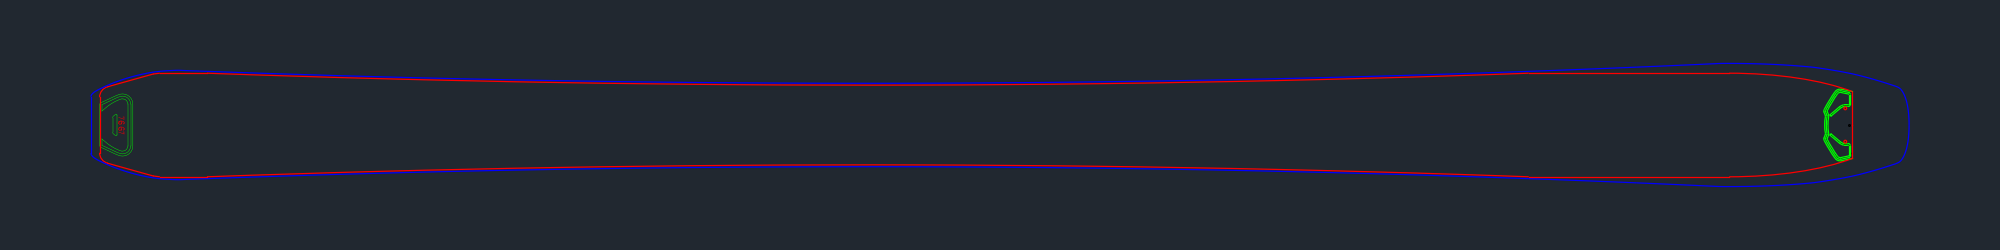

In [477]:
# Safe loading procedure of dxf file(requires ezdxf v0.14):
# The auditor.errors attribute stores severe errors,
# which may raise exceptions when rendering.

try:
    doc, auditor = recover.readfile(original_dxf)
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)

# Printing the dxf content
if not auditor.has_errors:
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc.modelspace(), finalize=True)
    # Saving dxf content in png image
    #fig.savefig('your.png', dpi=300)

## Tail
Loading and plot tail of the skin

<IPython.core.display.Javascript object>


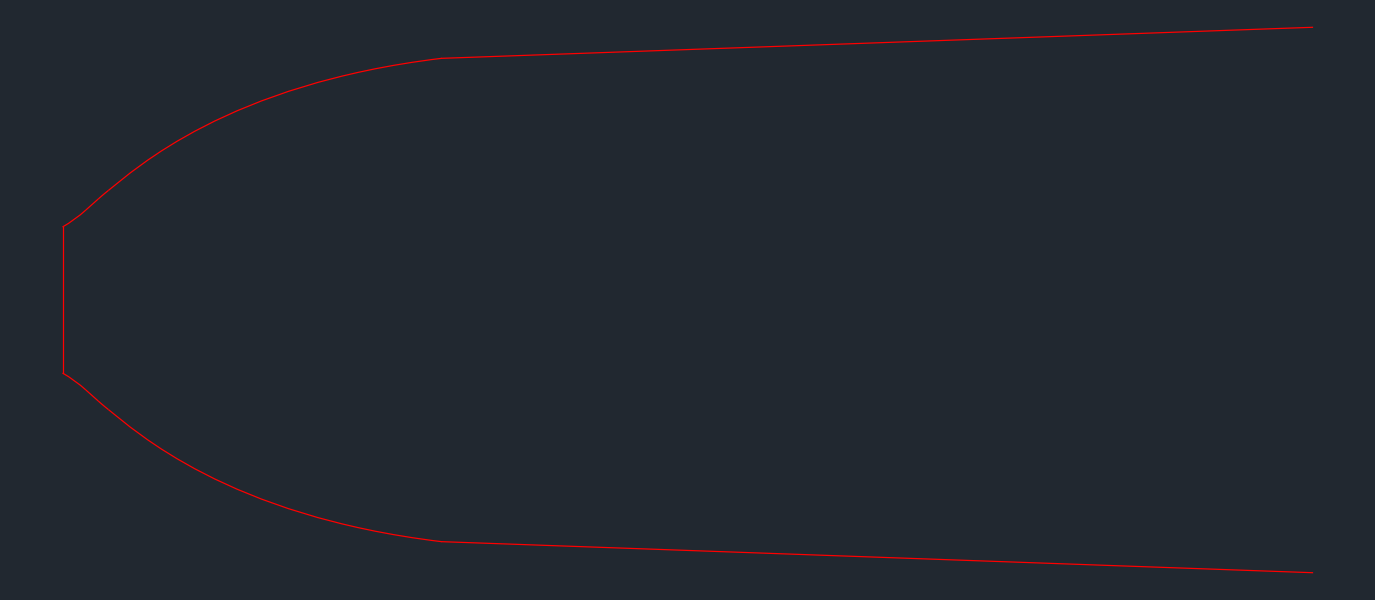

In [478]:
# Safe loading procedure of dxf file(requires ezdxf v0.14):
# The auditor.errors attribute stores severe errors,
# which may raise exceptions when rendering.

try:
    doc_tail, auditor_tail = recover.readfile(tail_dxf)
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)

# Printing the dxf content
if not auditor.has_errors:
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc_tail)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc_tail.modelspace(), finalize=True)
    # Saving dxf content in png image
    #fig.savefig('your.png', dpi=300)
    

View the content of the tail dxf

In [479]:
msp_tail = doc_tail.modelspace()
group = msp_tail.groupby(dxfattrib='layer')

for layer, entities in group.items():
    print(f'Layer "{layer}" contains following entities:')
    for entity in entities:
        print('    {}'.format(str(entity)))

Layer "0_PEAU" contains following entities:
    SPLINE(#490B)
    POLYLINE(#490C)
    POLYLINE(#4910)
    SPLINE(#4916)
    SPLINE(#4917)
    POLYLINE(#4918)
    POLYLINE(#491C)
    SPLINE(#4922)
    LINE(#4923)
    LINE(#497A)
    LINE(#497B)


Saving splines, polylines and lines points

<IPython.core.display.Javascript object>


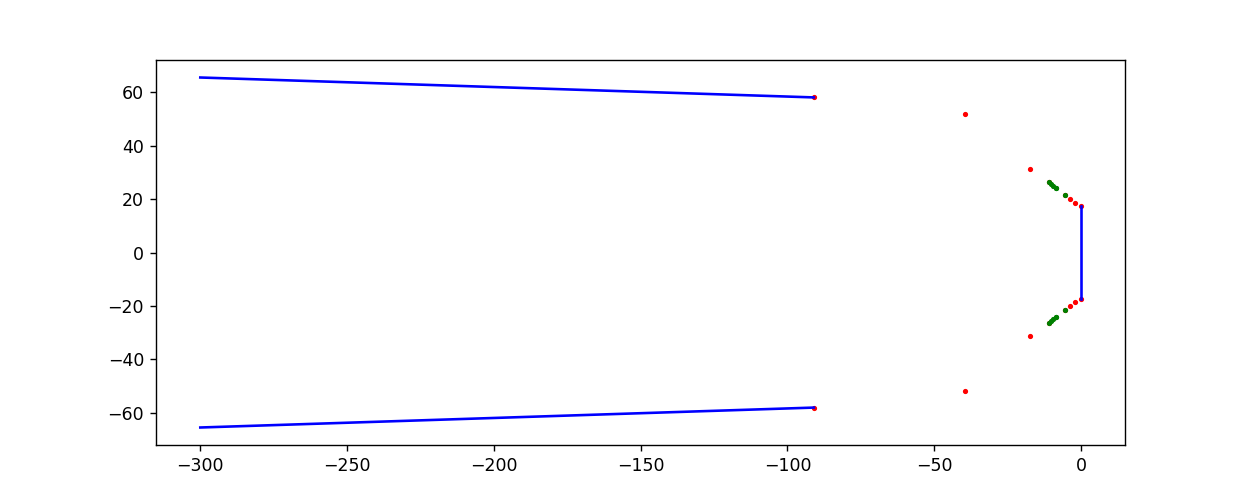

splines_points_tail
[array([[ 0.        , 17.52315146],
       [ 1.98956255, 18.67589216],
       [ 3.86902369, 20.03679168],
       [ 5.60440945, 21.59284812]])]
splines_points_tail
[array([[ 0.        , 17.52315146],
       [ 1.98956255, 18.67589216],
       [ 3.86902369, 20.03679168],
       [ 5.60440945, 21.59284812]]), array([[91.        , 58.        ],
       [39.53132288, 51.84089251],
       [17.42711588, 31.35159785],
       [10.99994574, 26.28058955]])]


In [480]:
plt.figure(figsize=(10, 4))

#Save and plot all spline points of the tail
splines_points_tail = list()
for spline in msp_tail.query('SPLINE[layer=="0_PEAU"]'):
    
    fitpoints = spline.fit_points.__str__() 
    controlpoints = spline.control_points.__str__() 
    knots = spline.knots.__str__() 
    weights = spline.weights.__str__() 
    if np.array(spline.control_points)[0,1] >= 0:
        splines_points_tail.append((np.take(np.array(spline.control_points),[0,1],axis=1)))
        print('splines_points_tail')
        print(splines_points_tail)
    
    plt.plot(-(np.array(spline.control_points)[:,0]),np.array(spline.control_points)[:,1], 'ro', markersize = 2)

#Save and plot all polyline points of the tail
polyline_points_tail = list()
for polyline in msp_tail.query('POLYLINE[layer=="0_PEAU"]'):
    
    polyline_points = polyline.vertices[:]
   
    polyline_points = np.array(polyline_points)
    
    for point in polyline_points:
        newpoint = point.format(format='xy') 
        if newpoint[1] >= 0:
            polyline_points_tail.append((np.reshape(newpoint,(1,2))))
        #print('polyline_points_tail')
        #print(polyline_points_tail)
        plt.plot(-newpoint[0], newpoint[1], 'go', markersize = 2)
    #plt.plot(np.array(polyline.control_points)[:,0],np.array(spline.control_points)[:,1], 'ro', markersize = 2)

#Save and plot all the lines of the tail
lines_points_tail = list()
for line in msp_tail.query('LINE[layer=="0_PEAU"]'):
    plt.plot([-(np.array(line.dxf.start)[0]),-(np.array(line.dxf.end)[0])],[(np.array(line.dxf.start)[1]),(np.array(line.dxf.end)[1])],'b-')
    #if np.array(line.dxf.start)[0] < max_splines_tail:
       
    lines_points_tail.append(np.take(np.array(line.dxf.start),[0,1],axis=0))
        
    lines_points_tail.append(np.take(np.array(line.dxf.end),[0,1],axis=0))
    #print('lines_points_tail')
    #print(lines_points_tail)

#splines_points_tail = splines_points_tail[np.argsort(splines_points_tail[:, 0])]
#splines_points_tail = splines_points_tail/10

## Tip
Loading and plot tip of the skin

<IPython.core.display.Javascript object>


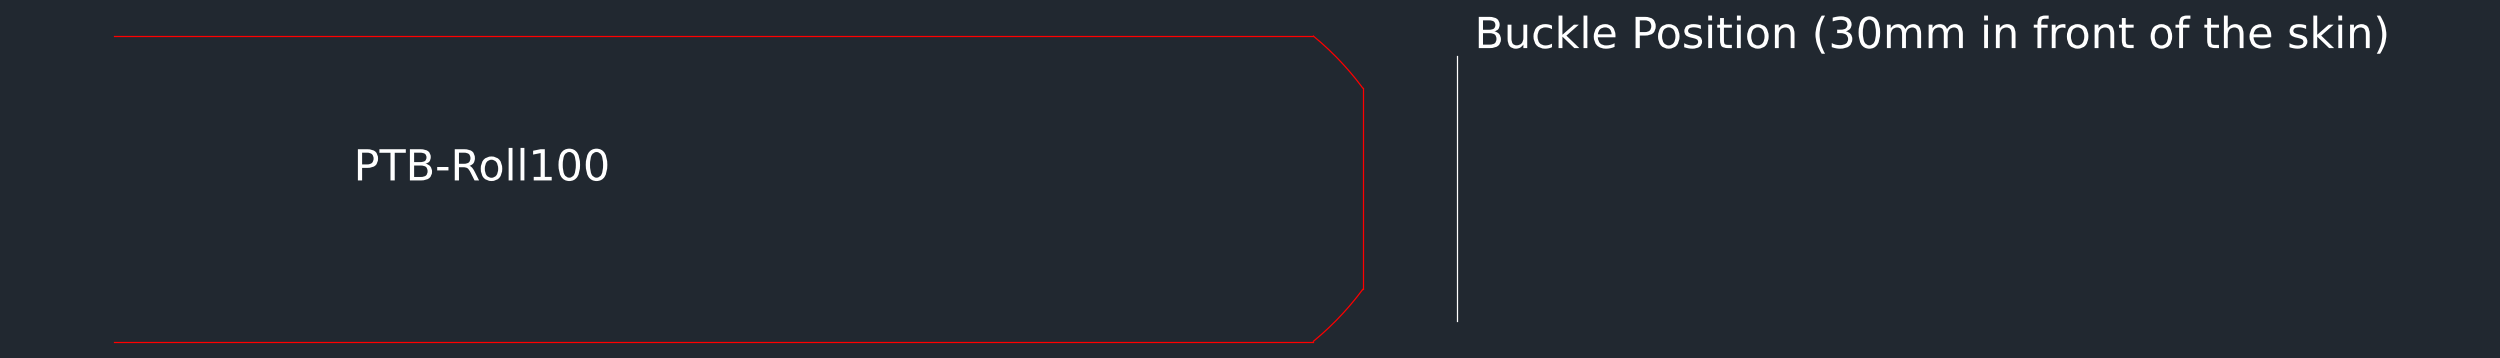

In [481]:
# Safe loading procedure of dxf file(requires ezdxf v0.14):
# The auditor.errors attribute stores severe errors,
# which may raise exceptions when rendering.

try:
    doc_tip, auditor_tip = recover.readfile(tip_dxf)
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)

# Printing the dxf content
if not auditor.has_errors:
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc_tip)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc_tip.modelspace(), finalize=True)
    # Saving dxf content in png image
    #fig.savefig('your.png', dpi=300)

View the content of the tip dxf

In [482]:
msp_tip = doc_tip.modelspace()
group = msp_tip.groupby(dxfattrib='layer')

for layer, entities in group.items():
    print(f'Layer "{layer}" contains following entities:')
    for entity in entities:
        print('    {}'.format(str(entity)))

Layer "0_PEAU" contains following entities:
    LINE(#4A64)
    LINE(#4A65)
    LINE(#4A66)
    SPLINE(#4A67)
    LINE(#4A68)
    SPLINE(#4A69)
    LINE(#4A6A)
Layer "5_CARTOUCHE" contains following entities:
    LINE(#4A6B)
    MTEXT(#4A6C)
    MTEXT(#4A6D)


Saving splines, polylines and lines points

<IPython.core.display.Javascript object>


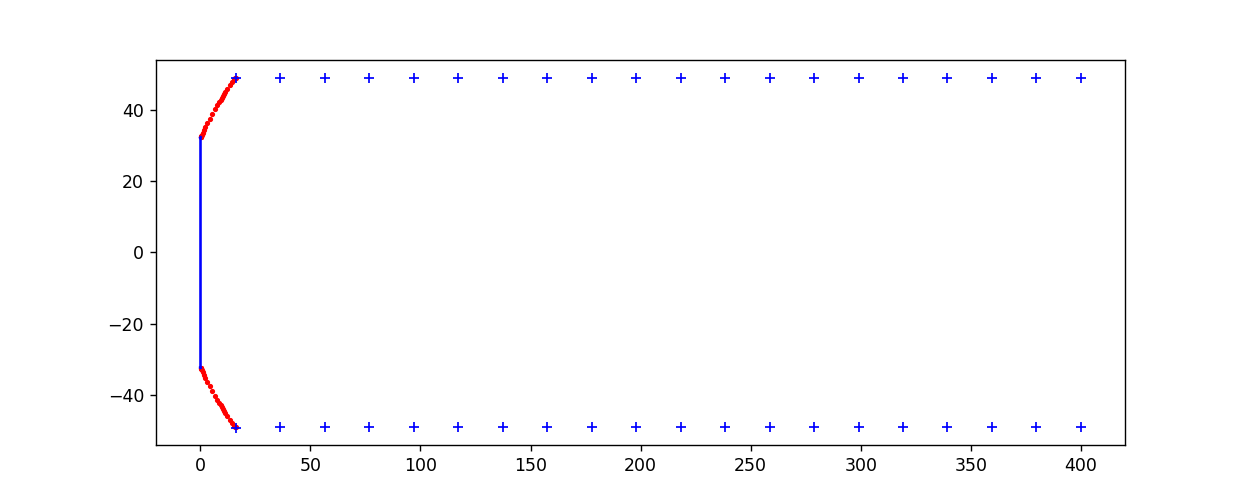

-0.0
Line end x and y
-0.0
32.1597074972683
-0.0
Line end x and y
-0.0
-32.1597074972683
-0.0
Line end x and y
-0.0
-32.1597074972683
400.0
Line end x and y
400.0
48.99998397369654
400.0
Line end x and y
400.0
-49.00001602630309
lines_points_tip
[array([-0.13931263, 32.2963794 ]), array([ 0.       , 32.1597075]), array([ -0.13931263, -32.2963794 ]), array([  0.       , -32.1597075]), array([ 0.       , 32.1597075]), array([  0.       , -32.1597075])]
lines_point_tip_intersect
[array([[ 16.05930045,  36.26670569,  56.47411093,  76.68151617,
         96.88892141, 117.09632665, 137.30373189, 157.51113713,
        177.71854237, 197.9259476 , 218.13335284, 238.34075808,
        258.54816332, 278.75556856, 298.9629738 , 319.17037904,
        339.37778428, 359.58518952, 379.79259476, 400.        ],
       [ 48.99998397,  48.99998397,  48.99998397,  48.99998397,
         48.99998397,  48.99998397,  48.99998397,  48.99998397,
         48.99998397,  48.99998397,  48.99998397,  48.99998397,
     

In [483]:
threshold = 10 #mm

plt.figure(figsize=(10, 4))
#Save and plot all spline points of the tip
splines_points_tip = list()
for spline in msp_tip.query('SPLINE[layer=="0_PEAU"]'):
    
    fitpoints = spline.fit_points.__str__() 
    controlpoints = spline.control_points.__str__() 
    knots = spline.knots.__str__() 
    weights = spline.weights.__str__() 
    if np.array(spline.control_points)[0,1] >= 0:
        splines_points_tip.append((np.take(np.array(spline.control_points),[0,1],axis=1)))
        #print('splines_points_tip')
        #print(splines_points_tip)
    
    plt.plot(-(np.array(spline.control_points)[:,0]),np.array(spline.control_points)[:,1], 'ro', markersize = 2)

#Save and plot all polyline points of the tip
polyline_points_tip = list()
for polyline in msp_tip.query('POLYLINE[layer=="0_PEAU"]'):
    
    polyline_points = polyline.vertices[:]
   
    polyline_points = np.array(polyline_points)
    
    for point in polyline_points:
        newpoint = point.format(format='xy') 
        if newpoint[1] >= 0:
            polyline_points_tip.append((np.reshape(newpoint,(1,2))))
        print('polyline_points_tip')
        print(polyline_points_tip)
        plt.plot(-newpoint[0], newpoint[1], 'go', markersize = 2)

#Save and plot all the lines of the tip
lines_points_tip = list()
lines_point_tip_intersect = list()
for line in msp_tip.query('LINE[layer=="0_PEAU"]'):
    print(-np.array(line.dxf.end)[0])
    if (-np.array(line.dxf.end)[0] >= threshold):
        p = np.polyfit([-(np.array(line.dxf.start)[0]),-(np.array(line.dxf.end)[0])],[(np.array(line.dxf.start)[1]),(np.array(line.dxf.end)[1])],1)
        x = np.linspace(-np.array(line.dxf.start)[0],-np.array(line.dxf.end)[0],20)
        y = np.polyval(p,x)
        plt.plot(x,y,'b+')
        lines_point_tip_intersect.append(np.vstack((x,y)))
    else:
        plt.plot([-(np.array(line.dxf.start)[0]),-(np.array(line.dxf.end)[0])],[(np.array(line.dxf.start)[1]),(np.array(line.dxf.end)[1])],'b-')


        #if np.array(line.dxf.start)[0] < max_splines_tail:

        lines_points_tip.append(np.take(np.array(line.dxf.start),[0,1],axis=0))

        lines_points_tip.append(np.take(np.array(line.dxf.end),[0,1],axis=0))
   # print('Line start x and y')
   # print(-np.array(line.dxf.start)[0])
   # print(np.array(line.dxf.start)[1])
    print('Line end x and y')
    print(-np.array(line.dxf.end)[0])
    print(np.array(line.dxf.end)[1])

print('lines_points_tip')
print(lines_points_tip)
print('lines_point_tip_intersect')
print(lines_point_tip_intersect)

plt.figure(figsize=(10, 4))
splines_points = list()
for spline in msp_tip.query('SPLINE[layer=="0_PEAU"]'):
    
    fitpoints = spline.fit_points.__str__() 
    controlpoints = spline.control_points.__str__() 
    knots = spline.knots.__str__() 
    weights = spline.weights.__str__() 
    x = -(np.array(spline.control_points)[:,0])
    print('x')
    print(x)
    y = np.array(spline.control_points)[:,1]
    print('y')
    print(y)
    
    if not(y.any() <= 0):
        splines_points.append(np.stack((np.transpose(x), np.transpose(y)))/10)
        print('splines_points')
        print(splines_points)
 
    plt.plot(-(np.array(spline.control_points)[:,0]),np.array(spline.control_points)[:,1], 'ro', markersize = 2)
    
lines_points = np.empty((5,2,2))
print(lines_points)
i = 0
for line in msp_tip.query('LINE[layer=="0_PEAU"]'):
    x = [-(np.array(line.dxf.start)[0]),-(np.array(line.dxf.end)[0])]
    y = [np.array(line.dxf.start)[1],np.array(line.dxf.end)[1]]
    lines_points[i,:,:] = (np.stack((np.transpose(x), np.transpose(y))))/10
    i = i+1 
    print(lines_points)
    plt.plot([-(np.array(line.dxf.start)[0]),-(np.array(line.dxf.end)[0])],[np.array(line.dxf.start)[1],np.array(line.dxf.end)[1]],'b-')
    

Plot ski profile from dxf

<IPython.core.display.Javascript object>


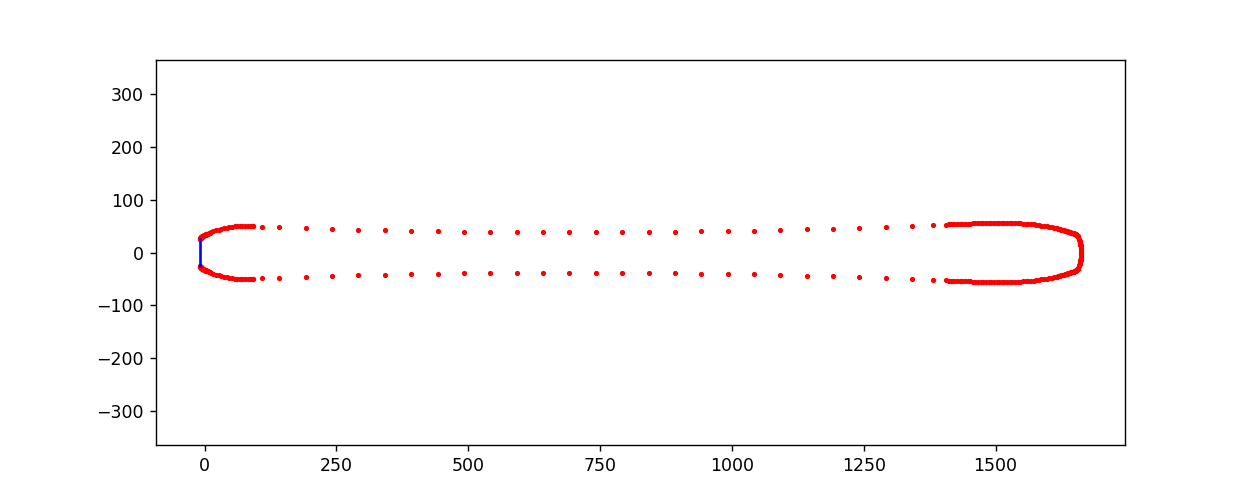

In [484]:
msp = doc.modelspace()
group = groupby(entities=msp, dxfattrib='layer')
group = msp.groupby(dxfattrib='layer')

plt.figure(figsize=(10, 4))

for spline in msp.query('SPLINE[layer=="2_Ski" | layer=="3_SKI" | layer=="0"]'):
    
    fitpoints = spline.fit_points.__str__() 
    controlpoints = spline.control_points.__str__() 
    knots = spline.knots.__str__() 
    weights = spline.weights.__str__() 
   
    plt.plot(np.array(spline.control_points)[:,0],np.array(spline.control_points)[:,1], 'ro', markersize = 2)

for arc in msp.query('ARC[layer=="2_Ski" | layer=="3_SKI" | layer=="0"]'):
    spline = arc.to_spline()
    plt.plot(np.array(spline.control_points)[:,0],np.array(spline.control_points)[:,1], 'ro', markersize = 2)
        
for line in msp.query('LINE[layer=="2_Ski" | layer=="3_SKI" | layer=="0"]'):
    plt.plot([np.array(line.dxf.start)[0],np.array(line.dxf.end)[0]],[np.array(line.dxf.start)[1],np.array(line.dxf.end)[1]],'b-')

plt.axis('equal')
plt.show()

In [485]:
def shift_data(x_points, minimum):
    
    out = x_points - minimum
    
    return out

In [486]:
tot_x = []
tot_y = []
for spline in msp.query('SPLINE[layer=="2_Ski" | layer=="3_SKI" | layer=="0"| layer=="Ski"]'):
    points = np.array(spline.control_points)
    x_nodes = points[:,0] 
   # x_nodes = shift_data(x_nodes_RAW, minimum)
    y_nodes = points[:,1]
    
    if x_nodes[0] > x_nodes[1]:
        x_nodes = x_nodes[::-1]
        y_nodes = y_nodes[::-1]
        
    if y_nodes[1]> 0:
        tot_x = np.append(tot_x,x_nodes)
        tot_y = np.append(tot_y,y_nodes)

tot_x = shift_data(tot_x, np.amin(tot_x))

nominal_min_width = np.amin(tot_y[50:-50])
print(nominal_min_width*2)
pos_nominal_min_width = tot_x[50+np.argmin(tot_y[50:-50])]
nominal_max_width = np.amax(tot_y)
print(nominal_max_width*2)
pos_nominal_max_width = tot_x[np.argmax(tot_y)]

#Flip data
tot_x = tot_x - np.amax(tot_x)
tot_x = -tot_x

tot_x = (np.flip(tot_x))/10
tot_y = (np.flip(tot_y))/10

start_spline = 0.12*(np.amax(tot_x))
end_spline = 0.97*(np.amax(tot_x))
x_spline = tot_x[(tot_x>start_spline) & (tot_x<end_spline)]
y_spline = tot_y[(tot_x>start_spline) & (tot_x<end_spline)]
dx = 0.5
myspline = scipy.interpolate.UnivariateSpline(x_spline, y_spline)
x_myspline = np.arange(x_spline[0], x_spline[-1], dx)
y_myspline = myspline(x_myspline)

76.58398281838856
113.18464325982404


## This is not required maybe for scanner data (to be fixed!!)

<class 'numpy.ndarray'>


<IPython.core.display.Javascript object>


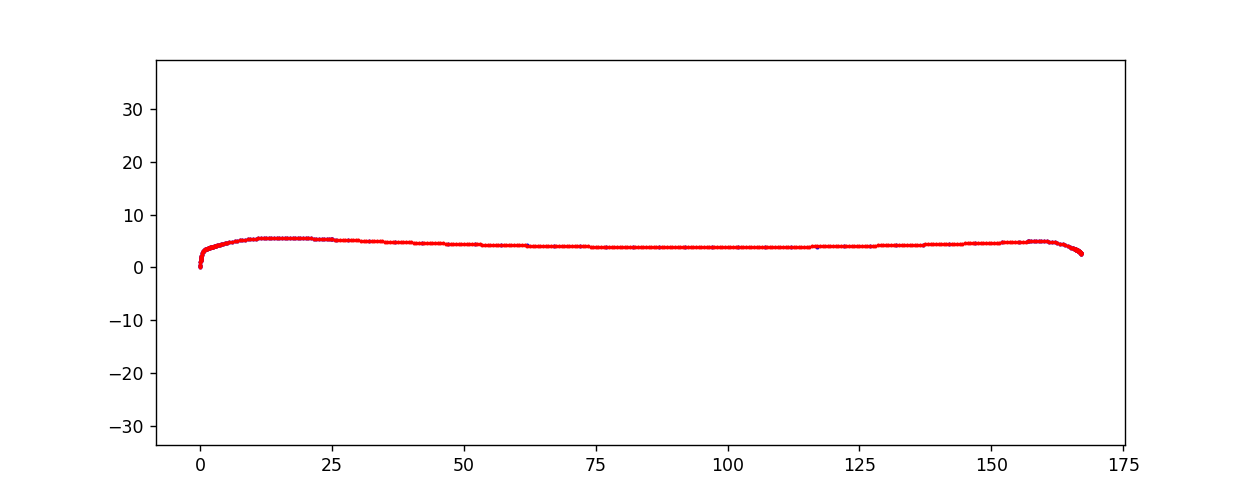

In [487]:
#Merge the original starting point and the ones from the interpolation
x_myspline_final = np.concatenate((tot_x[(tot_x<=(start_spline+5))], x_myspline[(x_myspline>(start_spline+5))&(x_myspline<(end_spline-5))], tot_x[(tot_x>=(end_spline-5))]))
y_myspline_final = np.concatenate((tot_y[(tot_x<=(start_spline+5))], y_myspline[(x_myspline>(start_spline+5))&(x_myspline<(end_spline-5))], tot_y[(tot_x>=(end_spline-5))]))
#y_myspline = np.concatenate((tot_y[(tot_x<=start_spline)], y_myspline, tot_y[(tot_x>=end_spline)]))

sectionA = np.vstack([x_myspline_final,y_myspline_final]).T
sectionA = sectionA[np.argsort(sectionA[:, 0])] #Sort the array
sectionA = np.unique(sectionA, axis=0) #Remove duplicates so to have no zero division error in add_spline
sectionB = np.copy(sectionA)
sectionB[:,1] = -sectionB[:,1]
#print(sectionA)
print(type(sectionA))

plt.figure(figsize=(10, 4))
plt.plot(tot_x, tot_y, 'b*', markersize = 2)
plt.plot(sectionA[:,0], sectionA[:,1], 'r*', markersize = 2)
#plt.plot(pos_nominal_min_width,nominal_min_width, 'go', markersize=4)
#plt.plot(pos_nominal_max_width,nominal_max_width, 'go', markersize=4)
plt.axis('equal')
plt.show()

# Skin profile computation
In this section we compute the skin profile with a 0.17 cm offset from the side of the ski and merging the tip and tail shapes from the ones chosen previously

In [488]:
#Setting parameters for skin drawing 

dist_from_tail = 6 #cm
dist_from_tip = 6 #cm
dist_from_side = 0.17 #cm
#dist_from_side_tip = 0.9 #cm this is the max distance from the side of the ski in the tip
#dist_from_side_tail = 0.9 #cm
buckle = 8.5 #cm
buckle_half = buckle/2
offset_start_skin = 3.4 #cm
print(buckle_half)
delta = 8 #cm needed to include some points of the ski profile to draw a spline (you need more points than the order of the interpolation)

4.25


Find the right point where the skin should start according to the type ok buckle

In [489]:
sectionA_temp = sectionA[sectionA[:,0]<5]
diff = abs(sectionA_temp[:,1]-buckle_half)
#print(diff)
start_buckle = np.where(sectionA_temp[:,0] == sectionA_temp[np.argmin(diff),0])
start_buckle = start_buckle[0]
print(sectionA[start_buckle,0])
start_skin = sectionA[start_buckle,0]+offset_start_skin
print(start_skin)
diff = abs(sectionA[:,0]-start_skin)

#Print distance form the closest point to the position I computed
print('Error from the required point')
print(np.amin(diff)) #Most probably you have got a difference of around 2 mm to get the closer point in the ski profile
start_skin_idx = np.where(sectionA[:,0] == sectionA[np.argmin(diff),0])
start_skin_idx = start_skin_idx[0]

dist_from_tip = start_skin

[3.39988214]
[6.79988214]
Error from the required point
0.19966230845809552


In [490]:
#Set line to intersect in the right position

lines_point_tip_intersect = np.array(lines_point_tip_intersect)/10
#print(lines_point_tip_intersect)
line_offset = lines_point_tip_intersect[0][0][0] #cm
print(line_offset)

#Set the correct offset to the line to intersect

lines_point_tip_intersect_def = np.vstack((lines_point_tip_intersect[0][0]+dist_from_tip,lines_point_tip_intersect[0][1]))
print(lines_point_tip_intersect_def[0][0])
print(lines_point_tip_intersect_def[1][0])

1.6059300448964902
8.405812187512584
4.899998397369653


In [491]:
#Set skin profile to intersect in the right position 

max_length = np.amax(sectionA[:,0])
print(max_length)
skin_profileA = sectionA[(sectionA[:,0] > dist_from_tip+line_offset) & (sectionA[:,0] < max_length-dist_from_tail)]
start_skin_profileA = skin_profileA[0,:]
print(start_skin_profileA)
#start_spline[1] = start_spline[1] - dist_from_side_tip
#skin_profileA = sectionA[(sectionA[:,0] > 0.14*max_length) & (sectionA[:,0] < max_length-dist_from_tail)]

#Subtract from ski profile the side offset
skin_profileA[:,1] = skin_profileA[:,1] - dist_from_side

167.0
[8.49923596 5.26529997]


## Find intersection

In [492]:
#Find the closer point to lines_point_tip_intersect_def[1][0]
diff = abs(skin_profileA[:,1]-lines_point_tip_intersect_def[1][0])
intersection = np.where(skin_profileA[:,1] == skin_profileA[np.argmin(diff),1])
skin_profileA = skin_profileA[intersection[0][0]:,:]
print(skin_profileA[0][0])

30.999983756096206


In [493]:
#Before intersection save points from the line, after intersection save points from the skin_profileA
lines_point_tip_intersect_def[0][np.where(lines_point_tip_intersect_def[0]<skin_profileA[0][0])]
#lines_point_tip_intersect_def[1][np.where(lines_point_tip_intersect_def[0]<skin_profileA[intersection,0][0][0])]
#skin_profileA[:,0]

array([ 8.40581219, 10.42655271, 12.44729324, 14.46803376, 16.48877428,
       18.50951481, 20.53025533, 22.55099586, 24.57173638, 26.5924769 ,
       28.61321743, 30.63395795])

In [494]:
skin_profileA_spline_x = np.insert(skin_profileA[:,0],0,lines_point_tip_intersect_def[0][np.where(lines_point_tip_intersect_def[0]<skin_profileA[0][0])],axis=0)
skin_profileA_spline_y = np.insert(skin_profileA[:,1],0,lines_point_tip_intersect_def[1][np.where(lines_point_tip_intersect_def[0]<skin_profileA[0][0])],axis=0)
skin_profileA_spline = np.transpose(np.vstack((skin_profileA_spline_x,skin_profileA_spline_y)))
#print(skin_profileA_spline)

[[  8.40581219   4.8999984 ]
 [ 10.42655271   4.8999984 ]
 [ 12.44729324   4.8999984 ]
 [ 14.46803376   4.8999984 ]
 [ 16.48877428   4.8999984 ]
 [ 18.50951481   4.8999984 ]
 [ 20.53025533   4.8999984 ]
 [ 22.55099586   4.8999984 ]
 [ 24.57173638   4.8999984 ]
 [ 26.5924769    4.8999984 ]
 [ 28.61321743   4.8999984 ]
 [ 30.63395795   4.8999984 ]
 [ 30.99998376   4.89611961]
 [ 31.49998376   4.87644944]
 [ 31.99998376   4.85694599]
 [ 32.49998376   4.83760908]
 [ 32.99998376   4.81843852]
 [ 33.49998376   4.79943413]
 [ 33.99998376   4.78059573]
 [ 34.49998376   4.76192312]
 [ 34.99998376   4.74341614]
 [ 35.49998376   4.72507459]
 [ 35.99998376   4.70689829]
 [ 36.49998376   4.68888706]
 [ 36.99998376   4.67104071]
 [ 37.49998376   4.65335907]
 [ 37.99998376   4.63584193]
 [ 38.49998376   4.61848913]
 [ 38.99998376   4.60130047]
 [ 39.49998376   4.58427578]
 [ 39.99998376   4.56741487]
 [ 40.49998376   4.55071756]
 [ 40.99998376   4.53418365]
 [ 41.49998376   4.51781298]
 [ 41.99998376

In [503]:
for spline in splines_points_tip:
    np.transpose(spline)
    spline[:,0] = -spline[:,0]+dist_from_tip
    print(spline)

[[ 6.66056952 32.2963794 ]
 [ 6.6260172  32.33744289]
 [ 6.53169343 32.46776189]
 [ 6.36243876 32.68298829]
 [ 6.10133598 33.02475646]
 [ 5.70898445 33.53398201]
 [ 5.14879033 34.2648504 ]
 [ 4.47179254 35.1385031 ]
 [ 3.52918972 36.26016571]
 [ 2.52564668 37.49875927]
 [ 1.3179472  38.83514559]
 [ 0.22832513 40.07645628]
 [-0.8461873  41.17782897]
 [-1.745489   42.15200917]
 [-2.45922709 42.83807849]
 [-2.99457445 43.3661151 ]
 [-3.43274211 43.79487076]
 [-3.97689862 44.33707855]
 [-4.64796736 44.95542764]
 [-5.52504142 45.7636067 ]
 [-6.61788206 46.77936908]
 [-7.80820759 47.76713129]
 [-8.70943858 48.54286293]
 [-9.12278069 48.89322584]
 [-9.25941831 48.99998397]]


This section interpolates the tip and tail with 0.9 cm of distance from the ski in the tip and in the tail (not used rn)

In [495]:
#skin_profileA = np.vstack([start_spline,skin_profileA])
#tip = skin_profileA[skin_profileA[:,0] < (0.14*max_length + delta)] #select a set of points for spline interpolation
#yspline = scipy.interpolate.UnivariateSpline(tip[:,0], tip[:,1])
#x = np.arange(tip[0,0], tip[-1,0], dx)
#tip_spline = yspline(x) # generate spline for the tip section
#final_tip = np.vstack([x,tip_spline]).T
#skin_profileA = np.vstack([final_tip,skin_profileA[skin_profileA[:,0] >= (0.14*max_length + delta)]])

#end_spline = skin_profileA[-1,:]
#end_spline[1] = end_spline[1] - (dist_from_side_tail+dist_from_side)
#start_tail = 0.9*(max_length-dist_from_tail)

#tail = skin_profileA[(skin_profileA[:,0]<start_tail) & (skin_profileA[:,0]>(start_tail-delta))]
#tail = np.vstack([tail,end_spline])

#yspline = scipy.interpolate.UnivariateSpline(tail[:,0], tail[:,1])
#x = np.arange(tail[0,0], tail[-1,0], dx)
#tail_spline = yspline(x) # generate spline for the tail section
#final_tail = np.vstack([x,tail_spline]).T

#skin_profileA = np.vstack([skin_profileA[skin_profileA[:,0]<=(start_tail-delta)], final_tail])

Add tip to skin profile

tip_length = np.amax(splines_points[0][0][:]) #keep points from spline to the tip #cm

delta = 10 # it can range from 0 to 30 according to the difference with the width of the ski   #TO BE FIXED

print(tip_length)
print(skin_profileA[:,0].min())
skin_profileA = skin_profileA[skin_profileA[:,0] > skin_profileA[:,0].min()+tip_length+delta]
print(skin_profileA[:,0].min())

tip_x = splines_points[0][0][:]
tip_x = np.flip(tip_x) + dist_from_tip
#tip_x = np.append(tip_x,skin_profileA[0,0])

tip_y = splines_points[0][1][:]
tip_y = np.flip(tip_y)
#tip_y = np.append(tip_y,skin_profileA[0,1])

yspline = scipy.interpolate.UnivariateSpline(tip_x, tip_y)
x = np.arange(tip_x[0], tip_x[-1], dx)
tip_spline = yspline(x) # generate spline for the tip section
final_tip = np.vstack([x,tip_spline]).T

skin_profileA = np.vstack([final_tip,skin_profileA[1:,:]])

plt.figure(figsize=(10, 4))
plt.plot(skin_profileA[:,0], skin_profileA[:,1], 'b*', markersize = 2)
plt.axis('equal')
plt.show()

Add tail to skin profile

tail_length = max_splines_tail/10
#print(tail_length)
dx=0.1
delta = 0 # it can range from 0 to 30 according to the difference with the width of the ski   #TO BE FIXED

skin_profileA = skin_profileA[skin_profileA[:,0] < skin_profileA[:,0].max()-tail_length-delta]
#print(skin_profileA[:,0].argmax())
max_length_tail = skin_profileA[skin_profileA[:,0].argmax(),0]
#print(max_length_tail)
max_width_tail = skin_profileA[skin_profileA[:,0].argmax(),1]
#print(max_width_tail)
splines_points_tail = splines_points_tail[splines_points_tail[:,1] <= max_width_tail]
#print('splines_points_tail')
#print(splines_points_tail)

tail_x = splines_points_tail[:,0]
#print(tail_x)
tail_x = -tail_x + skin_profileA[:,0].max() + tail_length
tail_x = np.flip(tail_x)
#print(tail_x)
#tip_x = np.append(tip_x,skin_profileA[0,0])

tail_y = splines_points_tail[:,1]
#print(tail_y)
tail_y = np.flip(tail_y)
#print(tail_y)
#tip_y = np.append(tip_y,skin_profileA[0,1])

yspline = scipy.interpolate.UnivariateSpline(tail_x, tail_y)
x = np.arange(tail_x[0], tail_x[-1], dx)
tail_spline = yspline(x) # generate spline for the tip section
final_tail = np.vstack([x,tail_spline]).T
print(final_tail)
skin_profileA = np.vstack([skin_profileA[:,:],final_tail])
print(skin_profileA)

Duplicate specular profile

In [496]:
skin_profileB = np.copy(skin_profileA_spline)
skin_profileB[:,1] = -skin_profileB[:,1] 

<IPython.core.display.Javascript object>


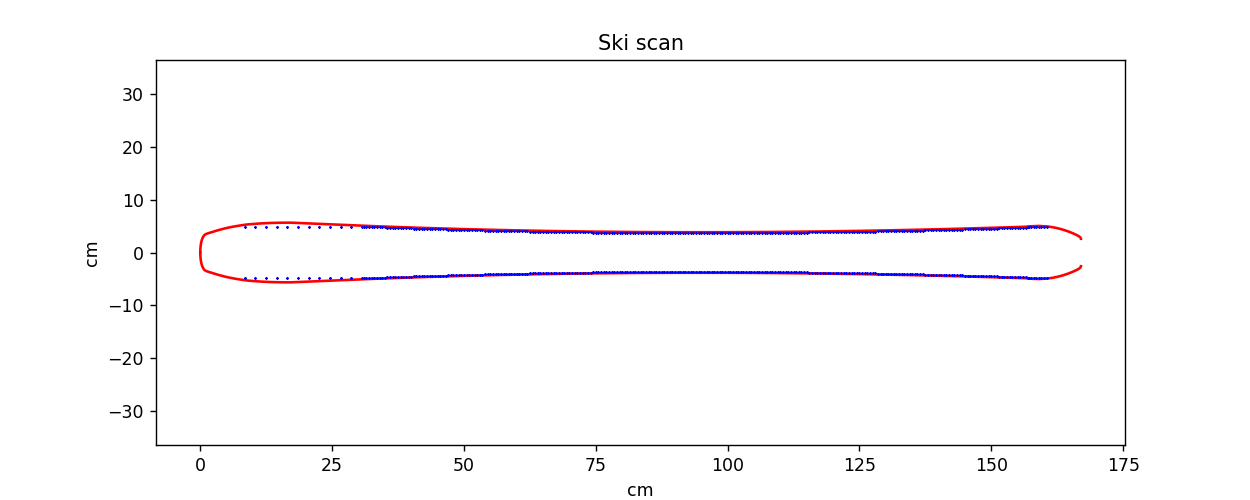

In [498]:
fig1 = plt.figure(figsize=(10, 4))

plt.plot(sectionA[:,0], sectionA[:,1], 'r-', markersize = 2)
plt.plot(sectionA[:,0], -sectionA[:,1], 'r-', markersize = 2)
plt.plot(skin_profileA_spline[:,0], skin_profileA_spline[:,1], 'b*', markersize = 1)
plt.plot(skin_profileB[:,0], skin_profileB[:,1], 'b*', markersize = 1)
#print(lines_points)

plt.title('Ski scan')
plt.axis('equal')
plt.xlabel('cm')
plt.ylabel('cm')
plt.show()

<IPython.core.display.Javascript object>


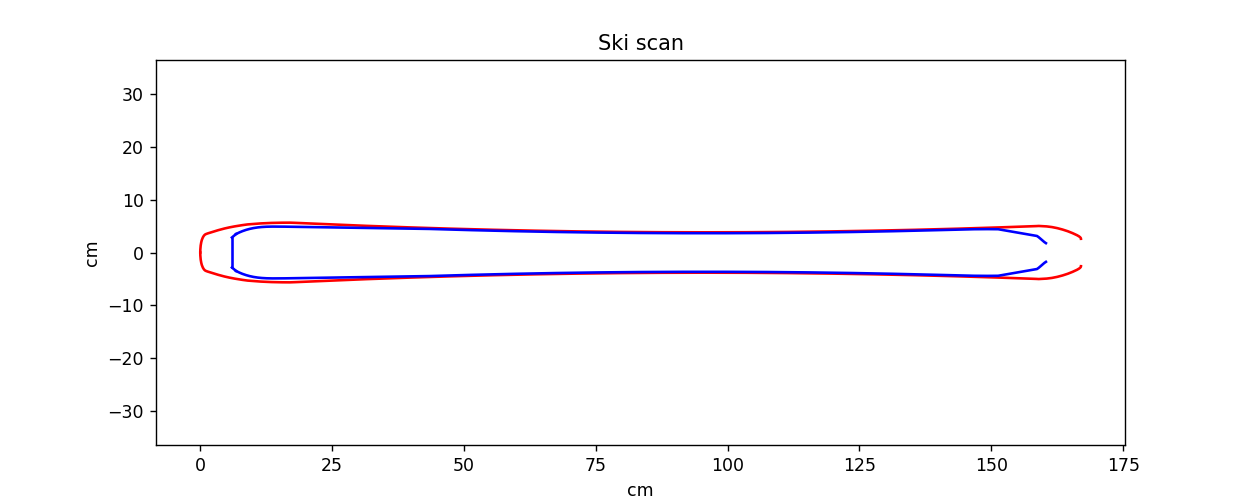

In [17]:
#Plot lines
lines_to_add = np.empty(shape=[0, 2])
for line in lines_points:
    if (line[0][0] < tip_length):
        line[0][:] = line[0][:] + dist_from_tip
        lines_to_add = np.concatenate((lines_to_add,line))
        plt.plot(line[0][:], line[1][:], 'b-', markersize = 1)
        


In [175]:
##Add just one single spline with smoothed control points
# Create a new DXF document
doc2 = dxf.new(dxfversion='R2018')
# DXF entities (LINE, TEXT, ...) reside in a layout (like modelspace).
msp2 = doc2.modelspace()

doc2.layers.new(name='Ski')
doc2.layers.new(name='Skin')
msp2.add_cad_spline_control_frame(fit_points = sectionA, dxfattribs={'layer': 'Ski'})
minimum = np.amin(sectionA[40:-40,1])
maximum = np.amax(sectionA[:,0])
maximum_width = np.amax(sectionA[:,1])

msp2.add_cad_spline_control_frame(fit_points = sectionB, dxfattribs={'layer': 'Ski'})

msp2.add_line((sectionA[0,0],sectionA[0,1]), (sectionB[0,0],sectionB[0,1]), dxfattribs={'layer': 'Ski'})
msp2.add_line((sectionA[-1,0],sectionA[-1,1]), (sectionB[-1,0],sectionB[-1,1]), dxfattribs={'layer': 'Ski'})

##Add skin_profile splines
msp2.add_cad_spline_control_frame(fit_points = skin_profileA, dxfattribs={'layer': 'Skin'})
msp2.add_cad_spline_control_frame(fit_points = skin_profileB, dxfattribs={'layer': 'Skin'})
#msp2.add_line((skin_profileA[0,0],skin_profileA[0,1]),(skin_profileB[0,0],skin_profileB[0,1]), dxfattribs={'layer': 'Skin'})
msp2.add_line((skin_profileA[-1,0],skin_profileA[-1,1]),(skin_profileB[-1,0],skin_profileB[-1,1]), dxfattribs={'layer': 'Skin'})

for line in lines_points:
    if (line[0][1] < (tip_length+dist_from_tip)):
        
        msp2.add_line((line[0][0],line[1][0]),(line[0][1],line[1][1]), dxfattribs={'layer': 'Skin'})
        print(line)

# Save DXF document.
doc2.saveas(dxf_filename)

[[6.         6.78585326]
 [2.84412226 3.50193718]]
[[ 6.          6.        ]
 [-2.84412226  2.84412226]]
[[ 6.          6.78585326]
 [-2.84412226 -3.50193718]]


<IPython.core.display.Javascript object>


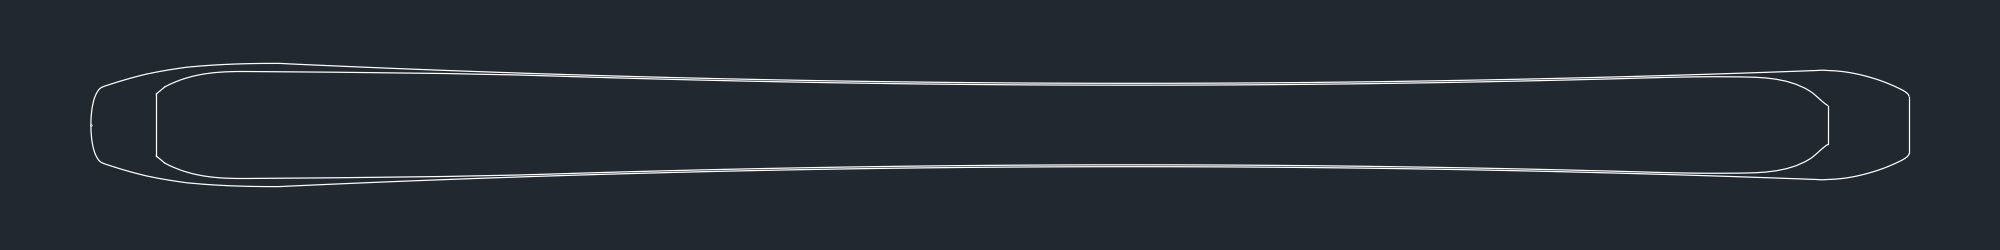

In [176]:
# Safe loading procedure of dxf file(requires ezdxf v0.14):
# The auditor.errors attribute stores severe errors,
# which may raise exceptions when rendering.
try:
    doc, auditor = recover.readfile(dxf_filename)
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)

# Printing the dxf content
if not auditor.has_errors:
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc.modelspace(), finalize=True)
    # Saving dxf content in png image
    #fig.savefig('your.png', dpi=300)